In [1]:
pip install keras-tuner --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import keras_tuner as kt

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [3]:
# Random seed for reproducibility
seed = 16

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
dataset_path = os.path.join('../input/anndlhw2data/Training.csv')

In [5]:
X = np.genfromtxt('../input/anndlhw2data/Training.csv',delimiter=',',skip_header=True)

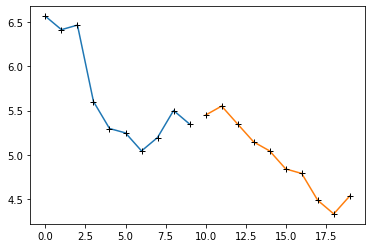

In [6]:
# Defining split sizes 

val_size = 1152
train_size = len(X) - val_size

train_raw = X[:train_size]
val_raw = X[train_size:]

train_raw.shape, val_raw.shape

plt.plot(figsize=(20,5))
plt.plot(range(10),train_raw[-10:,0])
plt.plot(range(10,20),val_raw[:10,0])
plt.plot(range(0,20),X[train_size-10:train_size+10,0],'+k')

In [7]:
# Pre-processing

train_max = train_raw.max(axis=0)
train_min = train_raw.min(axis=0)

X_mean = train_raw.mean(axis=0)
X_std = train_raw.std(axis=0)

train_scaled = (train_raw-train_min)/(train_max-train_min)
val_scaled = (val_raw-train_min)/(train_max-train_min)

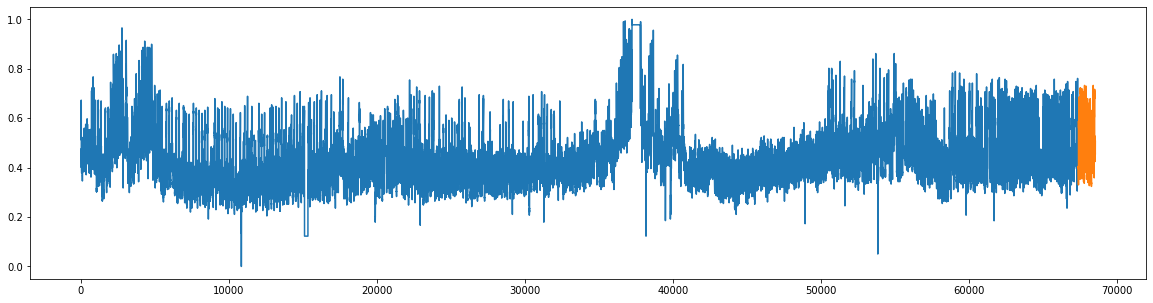

In [8]:
i = 0
plt.figure(figsize=(20,5))
plt.plot(train_scaled[:,i])
plt.plot(range(train_size, train_size+val_size),val_scaled[:,i])

In [9]:
# generate X, y
def extract_sequences(array,sequence_length = 200,stride=1,shuffle=True,seed=1):
   
    X = []
    y = []
    for i in range(0,len(array),stride):
        if i+sequence_length < len(array):
            X.append(array[i:i+sequence_length])
            y.append(array[i+sequence_length])
    X = np.array(X)
    y = np.array(y)
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(X)
        np.random.seed(seed)
        np.random.shuffle(y)
    return X, y

In [10]:
sequence_length = 400
stride = 1

X_train, y_train = extract_sequences(train_scaled,sequence_length,stride)
X_val, y_val = extract_sequences(val_scaled,sequence_length,stride)

X_train.shape,y_train.shape,X_val.shape,y_val.shape

((66976, 400, 7), (66976, 7), (752, 400, 7), (752, 7))

In [11]:
def build_lstm(hp):

    input_shape = X_train.shape[1:]
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.LSTM(units=hp.Int('units', min_value=128, max_value=512, step=16), return_sequences=False,return_state=False)(input_layer)
    
    if hp.Boolean("dropout"):
        x = tfkl.Dropout(rate=0.25)(x)
    
    output_layer = tfkl.Dense(7,bias_initializer=tfk.initializers.Constant(train_scaled.mean(axis=0)))(x)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(loss=tfk.losses.MeanSquaredError(), 
                  optimizer=tfk.optimizers.Adam(learning_rate = lr), 
                  metrics=['mae'])

    return model


In [12]:
#epochs = 100
#batch_size = 256
tuner = kt.RandomSearch(build_lstm,objective='val_loss',max_trials=5)

2022-01-11 11:52:13.241426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 11:52:13.369362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 11:52:13.370460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 11:52:13.372508: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [13]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 16, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [14]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Trial 5 Complete [00h 08m 25s]
val_loss: 0.0013414440909400582

Best val_loss So Far: 0.0013380200834944844
Total elapsed time: 01h 03m 13s


In [25]:
best_hps = tuner.get_best_hyperparameters()[0]

print(f"""Hyperparameter \t| Optimal Value \n
lstm units \t| {best_hps.get('units')}
dropout \t| {best_hps.get('dropout')}
learning rate \t| {best_hps.get('lr')} """)

Hyperparameter 	| Optimal Value 

lstm units 	| 352
dropout 	| True
learning rate 	| 0.00029945540285499357 


In [26]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 400, 7)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 352)               506880    
_________________________________________________________________
dropout (Dropout)            (None, 352)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 2471      
Total params: 509,351
Trainable params: 509,351
Non-trainable params: 0
_________________________________________________________________
